## Required Libraries

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import os
import random

In [79]:
import sys
sys.path.append('../src/')
import preprocess
import json2mask

In [80]:
ROOT_DIR='C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\'

In [81]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [84]:
image_paths=os.listdir('C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images')
mask_paths=os.listdir('C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks')

In [85]:
for i in range(len(image_paths)):
    image_paths[i]=ROOT_DIR+"images\\"+image_paths[i]

In [86]:
image_paths

['C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002387.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002403.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002411.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002419.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002427.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002435.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002443.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\images\\cfcu_002451.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internsh

## Json2Mask

In [87]:
for i in range(len(image_paths)):
    mask_paths[i]=ROOT_DIR+"masks\\"+mask_paths[i]

In [88]:
mask=plt.imread(mask_paths[0])

In [89]:
mask_paths

['C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002387.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002403.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002411.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002419.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002427.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002435.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002443.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Project\\data\\masks\\cfcu_002451.png',
 'C:\\Users\\Beytullah\\Documents\\GitHub\\FordOtosan-L4Highway-Internship-Proje

In [98]:
def visualize_example_pair(image_paths,mask_paths):
    random_idx=random.randint(0,len(image_paths))
    image=plt.imread(image_paths[random_idx])
    mask=plt.imread(mask_paths[random_idx])
    
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    

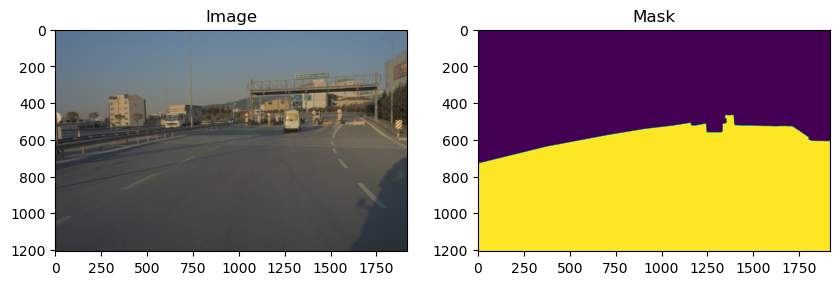

In [101]:
visualize_example_pair(image_paths,mask_paths)

# Preprocessing 

### torchlike_data() method

In [102]:
image_before_torchlike=image
print(f"Image shapes before torchlike_data() method {image_before_torchlike.shape}")

Image shapes before torchlike_data() method (1208, 1920, 3)


In [103]:
torch_like_data_example=preprocess.torchlike_data(image)

In [94]:
print(f"Image shapes before torchlike_data() method {torch_like_data_example.shape}")

Image shapes before torchlike_data() method (3, 1208, 1920)


We can see that at first our image has HeightxWidthxShape data format. Pytorch wants our images as ChannelxHeightxWidth format.

### onehot_encoder() method

## tensorize_image method

In [95]:
tensorized_images=preprocess.tensorize_image(image_paths,(224,224))

In [96]:
tensorized_images[0].shape

torch.Size([3, 224, 224])

In [97]:
tensorized_images[0]

tensor([[[ 68.,  67.,  67.,  ..., 154., 154., 155.],
         [ 68.,  68.,  71.,  ..., 155., 157., 156.],
         [ 68.,  70.,  68.,  ..., 154., 159., 155.],
         ...,
         [ 64.,  64.,  60.,  ...,  66.,  55.,  55.],
         [ 64.,  63.,  64.,  ...,  54.,  61.,  57.],
         [ 65.,  66.,  64.,  ...,  61.,  61.,  56.]],

        [[ 62.,  61.,  62.,  ..., 144., 141., 142.],
         [ 62.,  62.,  62.,  ..., 143., 144., 142.],
         [ 63.,  62.,  63.,  ..., 141., 143., 141.],
         ...,
         [ 53.,  56.,  51.,  ...,  53.,  49.,  51.],
         [ 53.,  56.,  56.,  ...,  49.,  53.,  50.],
         [ 54.,  55.,  58.,  ...,  54.,  52.,  49.]],

        [[ 56.,  56.,  57.,  ..., 126., 126., 127.],
         [ 59.,  57.,  60.,  ..., 128., 126., 127.],
         [ 56.,  57.,  58.,  ..., 129., 129., 126.],
         ...,
         [ 46.,  50.,  45.,  ...,  48.,  44.,  46.],
         [ 48.,  50.,  48.,  ...,  44.,  46.,  44.],
         [ 48.,  47.,  50.,  ...,  46.,  46.,  42.]]]

## one_hot_encoder method()

One hot encoding is a method that provides us to convert categorical data into vectors.  Fro now we have 2 categorical value wihich is pixel belong to freespace or not.

Returns a matrix containing as many channels as the number of unique
    values ​​in the input Matrix, where each channel represents a unique class.

(1208, 1920, 3)

In [22]:
preprocess.one_hot_encoder(image,2)

It should be same with the layer dimension, in this case it is 2
